In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("pastel")
from multiprocessing import Pool
from tqdm import tqdm

In [2]:
def init_worker(table):
    global shared_table
    shared_table = table

In [3]:
def process_indicator(data, indicator_name):
    # stack()：将列（股票ID）转为行，形成（时间, 股票ID）的二级索引
    long_df = data.stack(dropna = True).reset_index()
    # 重命名列：股票ID、时间、指标值
    long_df.columns = ['stock_id', 'time', 'value']
    # 添加指标类型列（如'post'、'high'）
    long_df['indicator'] = indicator_name
    return long_df

In [4]:
post_data = ff.read('post') * ff.filter0
high_data = ff.read('high') * post_data * ff.filter0
low_data = ff.read('low') * post_data * ff.filter0
close_data = ff.read('close') * post_data * ff.filter0
open_data = ff.read('open') * post_data * ff.filter0
next_uplimit_data = (ff.read('up_limit') * post_data * ff.filter0).shift(-1,axis = 1)
next_open_data = (ff.read('open') * post_data * ff.filter0).shift(-1,axis = 1)
vol_data = ff.read('vol') * ff.filter0

df_vol = process_indicator(vol_data, 'vol')
df_high = process_indicator(high_data, 'high')
df_low = process_indicator(low_data, 'low')
df_close = process_indicator(close_data, 'close')
df_open = process_indicator(open_data, 'open')
df_next_uplimit = process_indicator(next_uplimit_data, 'next_uplimit')
df_next_open = process_indicator(next_open_data, 'next_open')

long_table = pd.concat(
    [df_high, df_low, df_close, df_open, df_next_uplimit,df_next_open,df_vol],
    ignore_index=True
)
long_table['time'] = pd.to_datetime(long_table['time'])
init_worker(long_table)

In [5]:
stock_list = long_table['stock_id'].unique().tolist()

In [6]:
def climax_find(df):
    '''
    找到局部极值点
    ##输入：DataFrame index是日期 columns是high low open close
    ##输出：DataFrame index是日期 columns是high low open close peak_high peak_low
    # 创建peak列，默认值为NaN
    '''
    
    df['peak_high'] = False
    df['peak_low'] = False
    
    for i in range(len(df)):
        # 确定查找范围（防止越界）
        start = max(0, i - 1)
        end = min(len(df), i + 2)
        
        # 使用loc通过标签索引列
        current_high = df.loc[df.index[i], 'high']
        range_highs = df.loc[df.index[start:end], 'high']
        
        # 判断当前是否为局部高点
        if current_high == range_highs.max():
            df.loc[df.index[i], 'peak_high'] = True
            
        # 判断当前是否为局部低点
        current_low = df.loc[df.index[i], 'low']
        range_lows = df.loc[df.index[start:end], 'low']
        
        if current_low == range_lows.min():
            df.loc[df.index[i], 'peak_low'] = True
    
    return df

In [120]:
def platform_find(df):
    """
    查找价格平台（以当前K线为最新K线的平台高点）
    
    参数:
    df (pd.DataFrame): 包含K线数据的DataFrame，索引可为任意类型，
                      列包含'high', 'low', 'open', 'close', 'peak'
    
    返回:
    pd.DataFrame: 添加了'platform'列的DataFrame，记录平台高点和平台长度
    """
    # 创建platform列，默认值为NaN
    df['platform_high'] = np.nan
    df['platform_low'] = np.nan
    df['platform_length'] = np.nan
    df['platform_volatility_highlow'] = np.nan
    df['platform_volatility_open'] = np.nan
    df['average_vol'] = np.nan
    df['vol_trend'] = np.nan
    df['increase'] = np.nan
    df['increase_validity'] = np.nan
    df['daily_return'] = np.nan
    
    # 获取列的位置索引（确保兼容任意索引类型）
    peakhigh_col = df.columns.get_loc('peak_high')
    peaklow_col = df.columns.get_loc('peak_low')
    low_col = df.columns.get_loc('low')
    high_col = df.columns.get_loc('high')
    
    # 遍历每一行（从第1行开始，0-based索引）
    for i in range(1, len(df)):
        current_high_low = None  # 最近高点对应的低点
        current_low_high = None  # 最近低点对应的高点
        
        # 向前查找（从i-1到0）
        for j in range(i-1, -1, -1):
            # 使用iloc按位置访问，避免索引类型问题
            
            if df.iloc[j,peakhigh_col]:
                current_high_low = df.iloc[j, low_col]
            if df.iloc[j,peaklow_col]:
                current_low_high = df.iloc[j, high_col]
            
            # 当同时找到有效高点和低点，且满足高低点条件时
            if (current_high_low is not None and 
                current_low_high is not None and 
                current_high_low < current_low_high):
                
                # 计算j到i区间内的最高值作为平台高点
                platform_high = df.iloc[j:i, high_col].max()
                platform_low = df.iloc[j:i, low_col].min()
                df.iloc[i, df.columns.get_loc('platform_high')] = platform_high
                df.iloc[i, df.columns.get_loc('platform_low')] = platform_low
                df.iloc[i, df.columns.get_loc('platform_volatility_highlow')] = platform_high / platform_low - 1
                df.iloc[i, df.columns.get_loc('platform_volatility_open')] = df.iloc[i - 1]['open'] / df.iloc[j]['open']
                df.iloc[i, df.columns.get_loc('platform_length')] = i - j
                df.iloc[i, df.columns.get_loc('average_vol')] = df.iloc[j:i]['vol'].mean()
                df.iloc[i, df.columns.get_loc('vol_trend')] = df.iloc[(i + j - 1) // 2 + 1:i]['vol'].mean() / df.iloc[j:(i + j - 1) // 2]['vol'].mean()
                df.iloc[i, df.columns.get_loc('increase')] = df.iloc[i]['close'] / df.iloc[i]['open']
                df.iloc[i, df.columns.get_loc('increase_validity')] = df.iloc[i]['high'] / platform_high
                try:
                    daily_ret = (df.iloc[i + 2]['close'] - df.iloc[i + 1]['open']) / (2 * df.iloc[i + 1]['open'])    ##日均收益率
                except:
                    daily_ret = None
                df.iloc[i, df.columns.get_loc('daily_return')] = daily_ret
                break  # 找到平台后跳出内层循环
    
    return df

In [79]:
def stock_process(stock_id,start_date = '2020-01-01',end_date = '2025-07-20'):
    ##输入：单只股票的DataFrame index:日期 columns：高开低收
    ##输出：stock_id对应的所有连续突破信号df以及相关信息
    df = shared_table[shared_table['stock_id'] == stock_id]
    if df.empty:
        return pd.DataFrame(columns=['time', 'stock_id','platform_length','platform_volatility_highlow',
                                     'platform_volatility_open', 'vol_trend','vol_rate','increase','increase_validity'])
    else:
        stock_data = df.pivot(index='time',
                            columns='indicator',
                            values='value')
        stock_data.index = pd.to_datetime(stock_data.index)
        
        stock_data = climax_find(stock_data)
        stock_data = platform_find(stock_data)
        
        stock_data = stock_data[(stock_data.index >= start_date) & (stock_data.index <= end_date) & (stock_data['platform_length'].notna())]
        stock_data['breakthrough'] = stock_data['high'] > stock_data['platform_high']
        stock_data['vol_rate'] = stock_data['vol'] / stock_data['average_vol']
        stock_data = stock_data[stock_data['next_uplimit'] != stock_data['next_open']]
        result = stock_data[stock_data['breakthrough']]
        result_df = pd.DataFrame({
            'time': result.index,
            'stock_id': stock_id,
            'platform_length':result['platform_length'],
            'platform_volatility_highlow':result['platform_volatility_highlow'],
            'platform_volatility_open':result['platform_volatility_open'],
            'vol_trend':result['vol_trend'],
            'vol_rate':result['vol_rate'],
            'increase':result['increase'],
            'increase_validity':result['increase_validity'],
            'daily_return':result['daily_return']
        })
        
        return result_df.reset_index(drop = True)

In [119]:
with Pool(96, initializer = init_worker, initargs=(long_table,)) as p:
    # 直接使用 stock_process，不需要 partial
    res_lst = list(tqdm(p.imap(stock_process, stock_list), total = len(stock_list)))  ##一个list 元素是每支股票的所有信号

final_df_1 = pd.concat(res_lst, ignore_index=True)

  2%|█▎                                                                       | 96/5107 [00:17<15:24,  5.42it/s]Process ForkPoolWorker-581:
Process ForkPoolWorker-580:
Process ForkPoolWorker-570:
Process ForkPoolWorker-577:
Process ForkPoolWorker-604:
Process ForkPoolWorker-582:
Process ForkPoolWorker-600:
Process ForkPoolWorker-601:
Process ForkPoolWorker-516:
Traceback (most recent call last):
  File "/home/wangs/anaconda3/envs/py39/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/wangs/anaconda3/envs/py39/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/wangs/anaconda3/envs/py39/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/tmp/ipykernel_989772/2061388184.py", line 14, in stock_process
    stock_data = climax_find(stock_data)



KeyboardInterrupt: 

In [81]:
final_df_1

,time,stock_id,platform_length,platform_volatility_highlow,platform_volatility_open,vol_trend,vol_rate,increase,increase_validity,daily_return
0,2020-01-02,000001.SZ,3.0,0.051553,1.002420,0.675676,1.685285,1.013213,1.001181,0.003837
1,2020-01-03,000001.SZ,4.0,0.052795,1.007260,1.071709,1.049494,1.014168,1.021239,0.004115
2,2020-01-06,000001.SZ,5.0,0.075155,1.024803,1.310407,0.802623,1.003527,1.001733,-0.013719
3,2020-02-11,000001.SZ,4.0,0.041259,0.994517,0.759145,1.139326,1.013014,1.003358,-0.004733
4,2020-02-14,000001.SZ,7.0,0.044755,1.008225,0.969231,1.255466,1.018983,1.013387,0.005319
...,...,...,...,...,...,...,...,...,...,...
1182910,2025-06-03,689009.SH,2.0,0.049211,0.992403,NaN,1.127424,1.014934,1.006849,-0.004110
1182911,2025-06-23,689009.SH,3.0,0.056407,0.989992,0.944503,1.525807,0.977955,1.000165,0.000339
1182912,2025-07-03,689009.SH,8.0,0.052549,0.976297,0.875197,1.588589,1.049898,1.017631,-0.019416
1182913,2025-07-14,689009.SH,3.0,0.031738,0.985054,0.683995,1.027485,1.023785,1.011430,-0.002022


In [82]:
def select_stocks(group):
    """
    对单个时间分组进行处理：
    1. 筛选platform_volatility_open的前20%（小于等于20%分位数）
    2. 从中选择increase_validity最小的10只股票
    3. 返回包含这些股票ID的DataFrame，索引为该组的日期
    """
    # 获取当前分组的日期（group是子DataFrame，time列值相同，取第一个即可）
    current_date = group['time'].iloc[0]  # 正确提取分组日期
    
    # 1. 计算20%分位数并筛选前20%的股票
    vol_threshold = group['platform_volatility_open'].quantile(0.2)
    top20_vol = group[group['platform_volatility_open'] <= vol_threshold].copy()
    
    # 2. 按increase_validity升序排序，取最小的10只（不足10只则取全部）
    selected = top20_vol.sort_values('increase_validity', ascending=True).head(10)
    
    # 3. 构建结果DataFrame：索引为日期，列为stock_id
    result = pd.DataFrame({
        'stock_id': selected['stock_id'],
        'daily_return':selected['daily_return'],
        'time': current_date  # 显式添加日期列
    })
    
    # 设置日期为索引（保持一行一个股票ID）
    result = result.set_index('time', drop=True)
    return result

# 使用方法
grouped = final_df_1.groupby('time').apply(select_stocks)


In [85]:
grouped = grouped.reset_index(level=1, drop=True)

In [89]:
grouped

,stock_id,daily_return
time,,
2020-01-02,002927.SZ,0.009564
2020-01-02,603991.SH,0.004300
2020-01-02,002793.SZ,-0.023776
2020-01-02,603329.SH,0.008168
2020-01-02,300504.SZ,0.010652
...,...,...
2025-07-18,603160.SH,0.013710
2025-07-18,603132.SH,0.009690
2025-07-18,300603.SZ,0.015678


In [96]:
def Kline_data_extract(df):
    ans = pd.DataFrame(0,index = range(6),columns = ['open','close','high','low'])
    count = 0
    for _,row in df.iterrows():
        time = _
        stock_id = row['stock_id']
        tem_df = shared_table[shared_table['stock_id'] == stock_id].pivot(values = 'value',index = 'time',columns = 'indicator')
        tem_df = tem_df.sort_index()
        num_idx = tem_df.index.get_loc(time)
        if num_idx + 6 > len(tem_df):
            continue
        basic_price = tem_df.iloc[num_idx]['open']
        ss = tem_df.iloc[num_idx:num_idx + 6][['open','close','high','low']].reset_index(drop = True) / basic_price
        if ss.isna().any().any():
            continue
        else:
            ans += ss
            count += 1
    return ans / count

In [97]:
Kline_data_extract(grouped.iloc[0:10])

,open,close,high,low
0,1.000000,1.015352,1.021307,0.991031
1,1.014060,1.013620,1.026043,1.005078
2,1.009640,1.021642,1.030501,0.997938
3,1.022256,1.030686,1.036333,1.014280
4,1.025539,1.009913,1.037771,1.004808
5,1.016588,1.028114,1.036734,1.014209


In [110]:
def process_single_stock(row):
    """
    处理单只股票的子函数（访问全局shared_table）
    参数:
    - row: df中的一行数据（索引为time，含stock_id列）
    返回:
    - 标准化后的6根K线数据（DataFrame）或None（无效数据）
    """
    time = row.name  # 时间取自行索引（原代码中的time = _）
    stock_id = row['stock_id']
    
    # 提取该股票的数据
    try:
        tem_df = shared_table[shared_table['stock_id'] == stock_id].pivot(
            values='value', index='time', columns='indicator'
        )
    except KeyError:
        return None  # 缺少必要列，返回无效
    
    # 排序并检查时间是否存在
    tem_df = tem_df.sort_index()
    if time not in tem_df.index:
        return None
    
    # 定位时间索引并检查是否有足够的K线
    try:
        num_idx = tem_df.index.get_loc(time)
    except KeyError:
        return None
    if num_idx + 6 > len(tem_df):
        return None
    
    # 计算标准化K线（除以基准价）
    basic_price = tem_df.iloc[num_idx]['open']
    if basic_price == 0:  # 避免除零错误
        return None
    ss = tem_df.iloc[num_idx:num_idx+6][['open', 'close', 'high', 'low']].reset_index(drop=True)
    ss = ss / basic_price
    
    # 检查是否有缺失值
    if ss.isna().any().any():
        return None
    return ss

def Kline_data_extract(df):
    """多进程提取K线数据（模仿stock_process的调用风格）"""
    # 准备任务列表：df中的每行作为一个任务
    task_list = [row for _, row in df.iterrows()]
    
    # 使用进程池并行处理
    with Pool(64) as p:
        # 用tqdm显示进度，imap迭代处理任务
        res_lst = list(tqdm(
            p.imap(process_single_stock, task_list),
            total=len(task_list),
            desc="Processing Kline Data"
        ))
    
    # 汇总有效结果
    ans = pd.DataFrame(0.0, index=range(6), columns=['open', 'close', 'high', 'low'])
    count = 0
    for ss in res_lst:
        if ss is not None:
            ans += ss
            count += 1
    
    return ans / count if count > 0 else ans

In [113]:
Kline_data = Kline_data_extract(grouped)

Processing Kline Data: 100%|██████████████████████████████████████████████| 13428/13428 [17:12<00:00, 13.00it/s]


In [114]:
Kline_data

,open,close,high,low
0,1.000000,1.011734,1.030516,0.985863
1,1.011068,1.012355,1.033451,0.991557
2,1.011528,1.013018,1.033772,0.992476
3,1.012454,1.013988,1.035227,0.993036
4,1.013388,1.014403,1.035863,0.993597
5,1.013562,1.014456,1.035604,0.994079


In [115]:
def depict_Kline(df,label):
    '''
    ##绘制k线图
    ##输入：DataFrame  index是日期（0-5） column是高开低收
    ##输出：画出每一天的k线图
    '''
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 计算K线实体高度和影线长度
    df['body'] = abs(df['close'] - df['open'])
    df['upper_shadow'] = df['high'] - df[['open', 'close']].max(axis=1)
    df['lower_shadow'] = df[['open', 'close']].min(axis=1) - df['low']
    
    # 设置涨跌颜色（红色表示上涨，绿色表示下跌）
    colors = ['red' if close >= open else 'green' for close, open in zip(df['close'], df['open'])]
    
    # 绘制K线
    for i, (index, row) in enumerate(df.iterrows()):
        # 使用索引作为X坐标
        x_pos = index
        
        # 绘制实体
        ax.bar(
            x_pos, row['body'], 
            bottom=min(row['open'], row['close']), 
            width=0.6, color=colors[i], alpha=0.8
        )
        
        # 绘制上影线和下影线
        ax.plot([x_pos, x_pos], 
                [row['high'], max(row['open'], row['close'])], 
                color='black', linewidth=1)
        ax.plot([x_pos, x_pos], 
                [min(row['open'], row['close']), row['low']], 
                color='black', linewidth=1)
    
    # 设置X轴刻度为索引值
    ax.set_xticks(df.index)
    
    # 添加网格线
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # 设置标题和标签
    ax.set_title('K线图', fontsize=16)
    ax.set_xlabel('交易日', fontsize=12)
    ax.set_ylabel('价格', fontsize=12)
    
    # 添加图例
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', edgecolor='black', label='上涨'),
        Patch(facecolor='green', edgecolor='black', label='下跌')
    ]
    ax.legend(handles = legend_elements, loc='upper left')
    plt.gca().legend([label])
    # 调整布局
    plt.tight_layout()
    
    return fig, ax

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'K线图'}, xlabel='交易日', ylabel='价格'>)

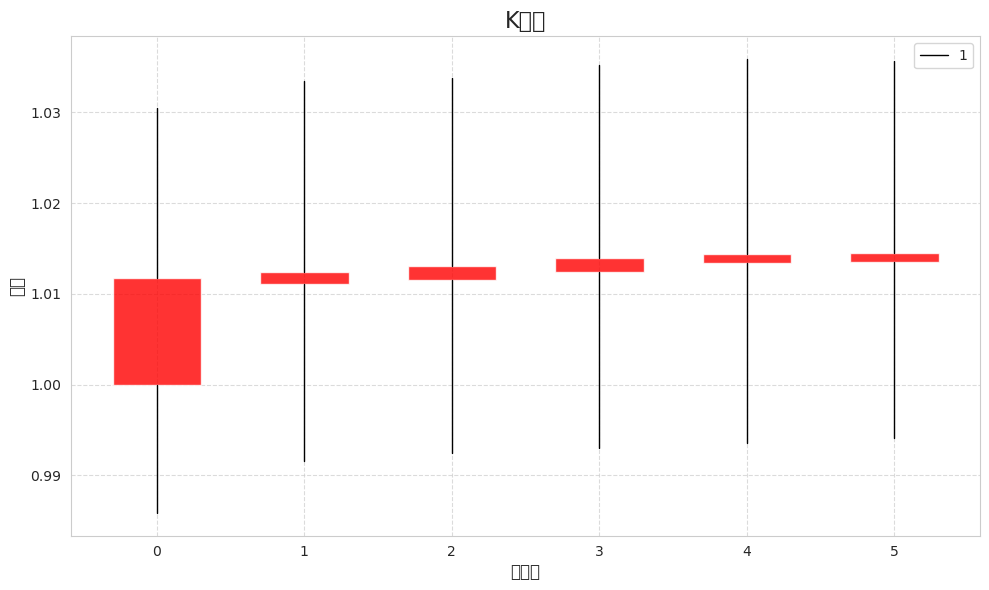

In [117]:
depict_Kline(Kline_data,1)